# **Diabetes classification**


## Import library

In [1]:
!pip install ucimlrepo

In [2]:
!pip install xgboost-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
import shap

## Exploratory Data Analysis

### Import dataset

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
DIABETES_DF = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = DIABETES_DF.data.features
y = DIABETES_DF.data.targets

X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [ ]:
print(type(X), X.shape, type(y), y.shape)

<class 'pandas.core.frame.DataFrame'> (253680, 21) <class 'pandas.core.frame.DataFrame'> (253680, 1)


CDC Diabetes Health Indicators dataset contains **253,680** instances and **21** features

### Features' descriptions

In [ ]:
DIABETES_DF.variables

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in you...,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not includ...,None,no


In [5]:
# get initial dataset for visualizing
original_df = DIABETES_DF.data.original

### Distribution of the features

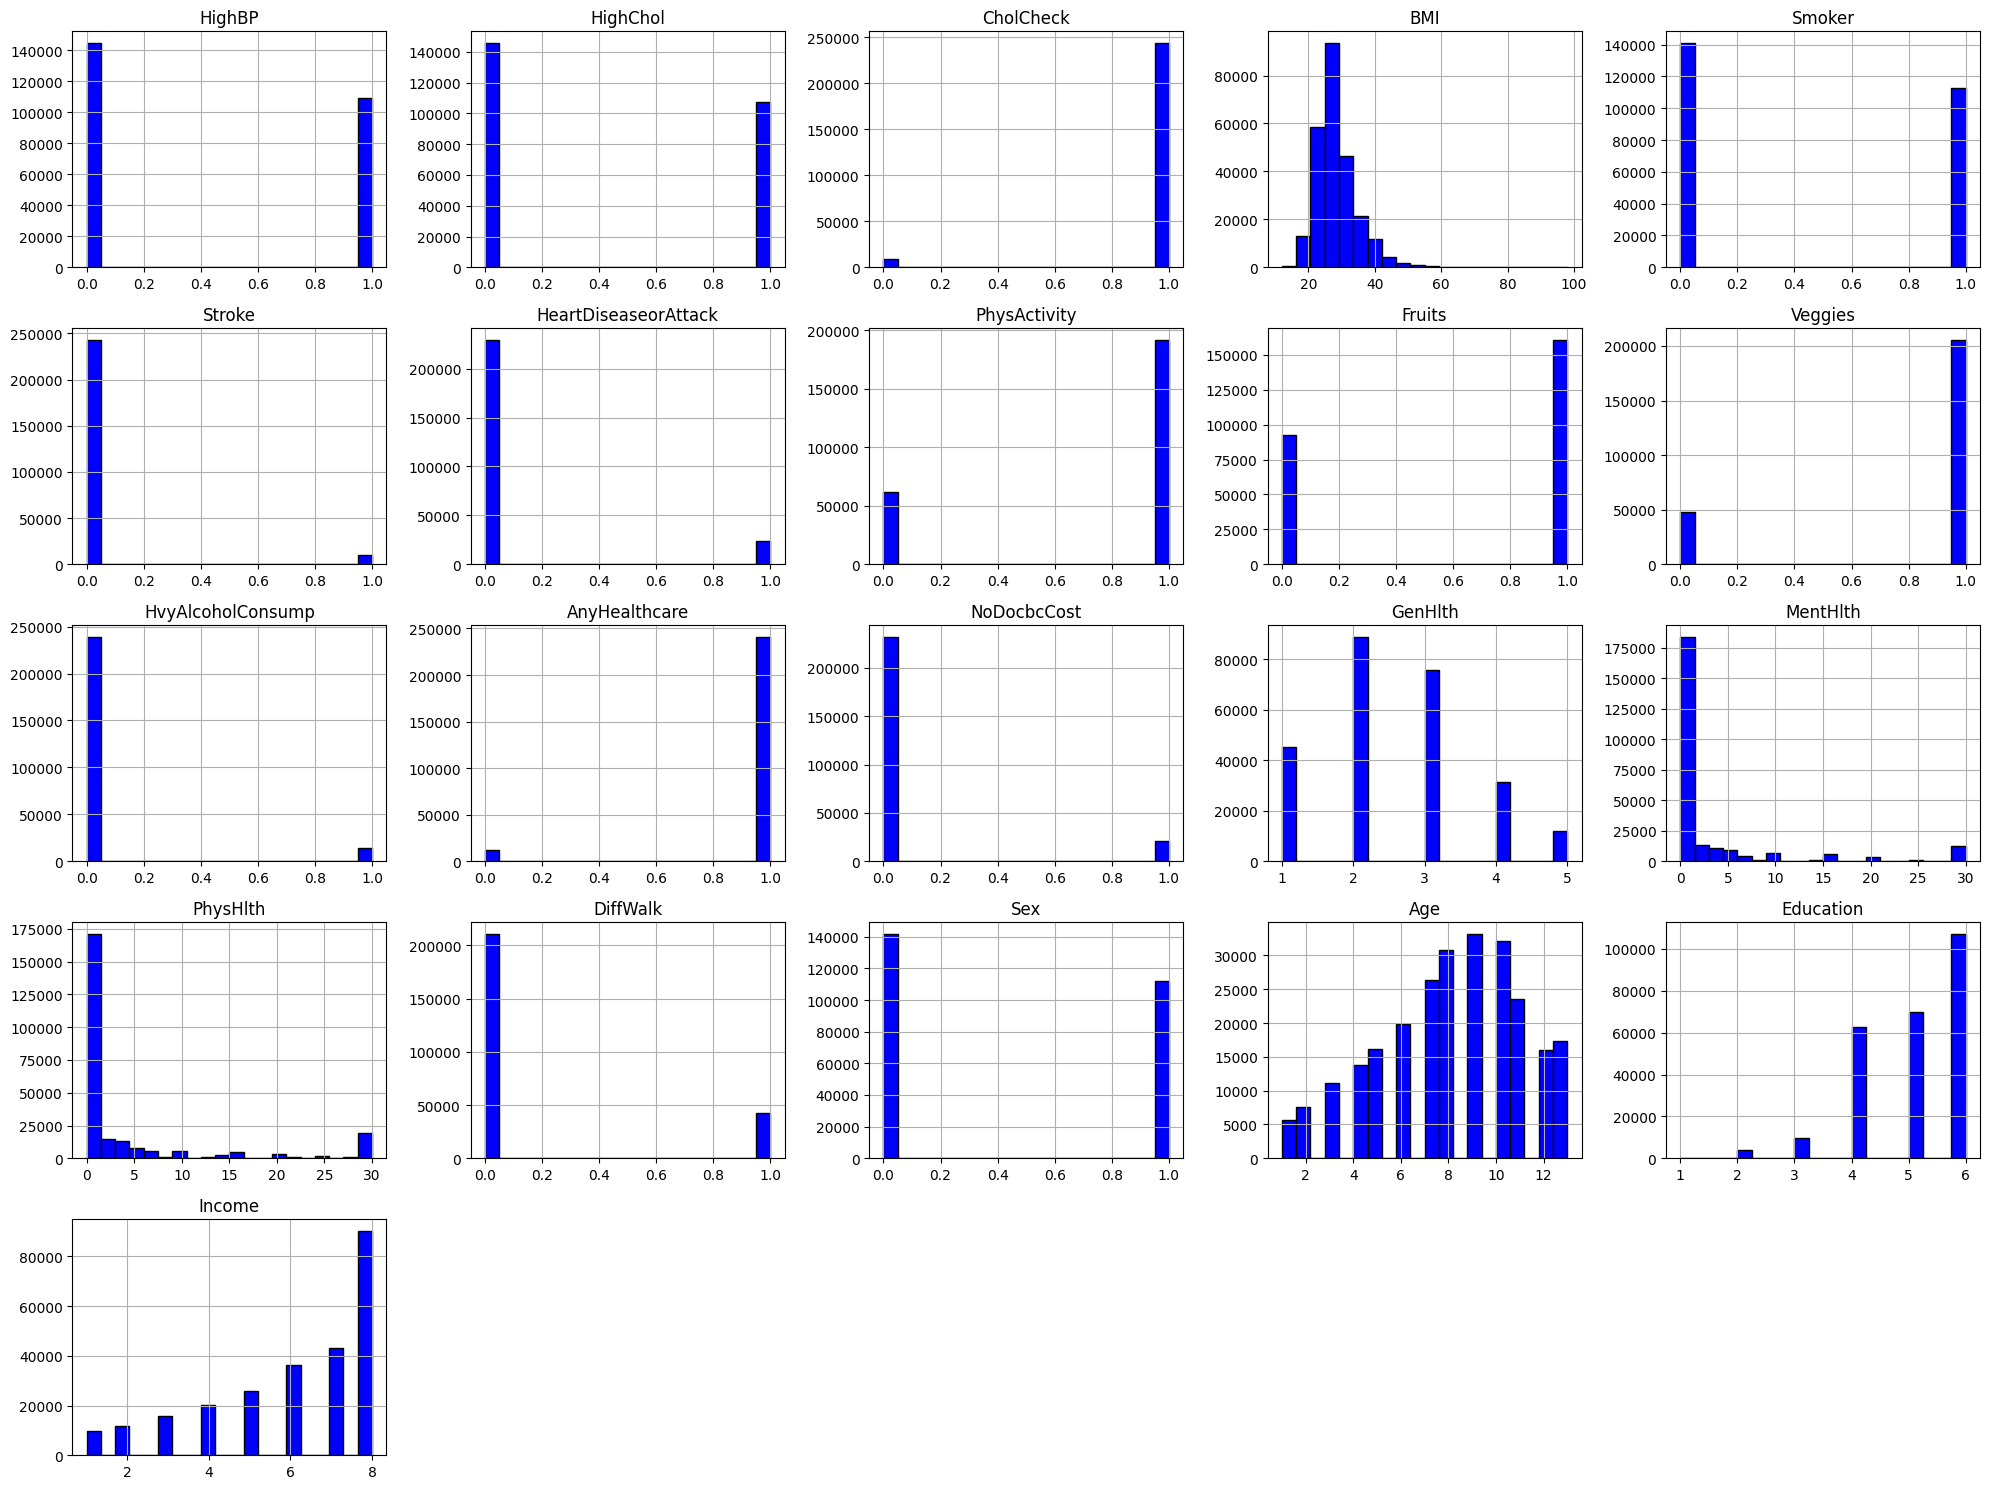

In [6]:
X.hist(bins=20, figsize=(20, 15), color='blue', edgecolor='black')

# Display the plot
plt.tight_layout()
plt.savefig('histogram.png')
plt.show()

### Distribution of the target variable

In [7]:
label_counts = y.value_counts()

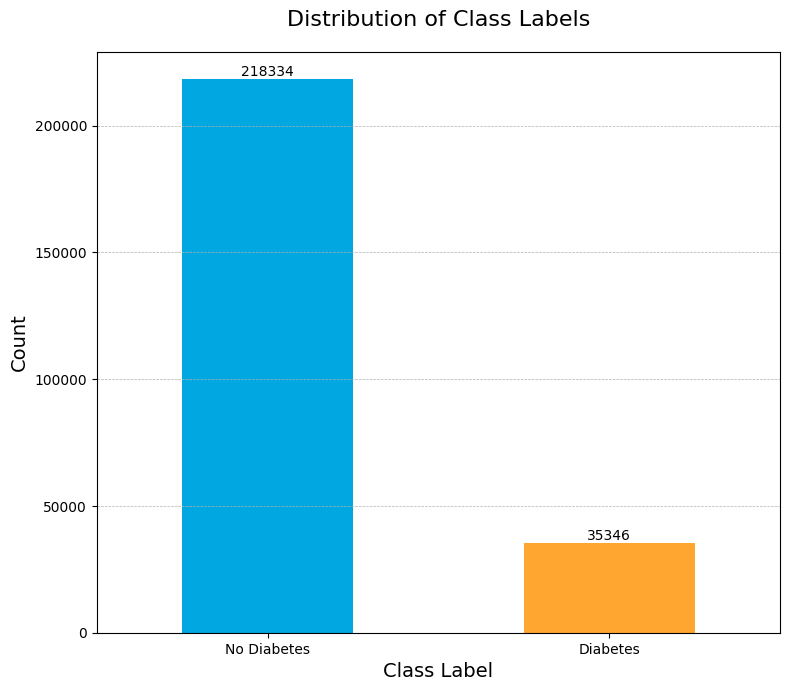

In [8]:
plt.figure(figsize=(8, 7))
ax = label_counts.plot(kind='bar', color=['#00a7e1', '#ffa630'])
plt.title('Distribution of Class Labels', fontsize=16, y=1.03)
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'], rotation=0)

for i, count in enumerate(label_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.grid(axis = 'y',  linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('diabetes-vs-non.png')
plt.show()

### Correlation coefficients heatmap

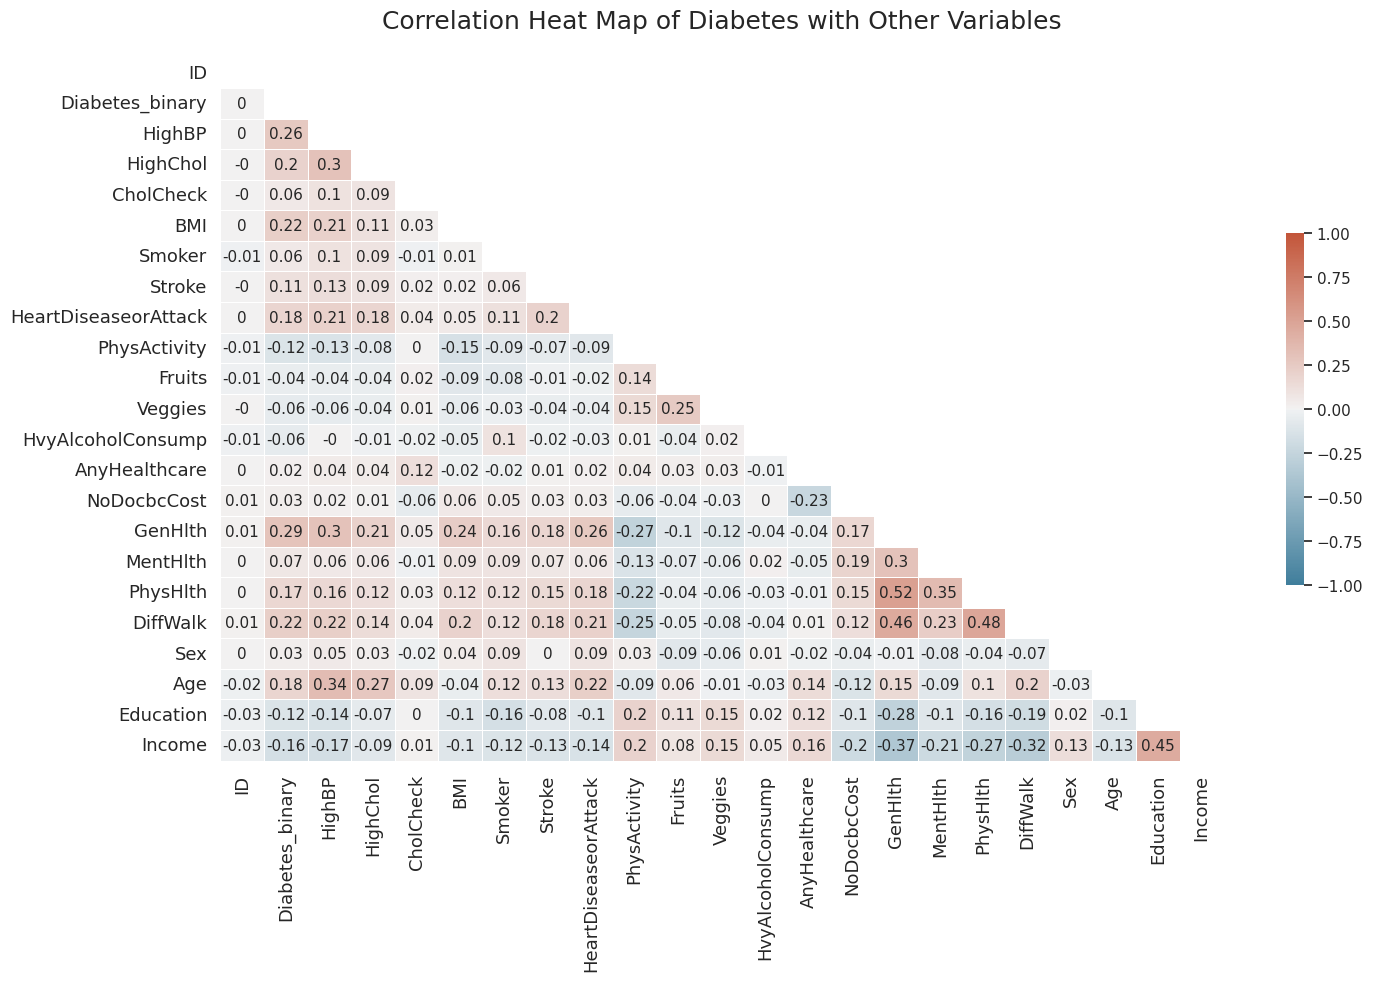

In [9]:
# compute the correlation matrix
coef = original_df.corr().round(2)

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(coef, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set_theme(style="white")

# set up the matplotlib figure
figure = plt.subplots(figsize=(15, 10))

# create heatmap
ax = sns.heatmap(coef, mask=mask, cmap=cmap,annot=True, vmin=-1, vmax=1,
                 linewidths=.5, center=0, annot_kws={'fontsize': 11}, cbar_kws={"shrink": .5})

# adjust tick fontsize fontsize
ax.tick_params(axis='both', labelsize=13)

ax.set_title("Correlation Heat Map of Diabetes with Other Variables",
             fontsize=18, y=1.03)

plt.tight_layout()
plt.savefig('correlation.png')
plt.show()

**Based on the standard threshold to filter out highly correlated variables (0.7-0.9), we keep all the variables**

## Preprocessing

In [10]:
# convert y to column
y = y.squeeze()

### Perform a `Stratified Sampling` of the data into training/validation/test sets with respective proportions of 60%/20%/20%.

#### Split data into `60%` training and `40%` remaining sets:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.4,
                                                        random_state=42, stratify=y)

#### Split remaining data into `20%` validation and `20%` test sets:

In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5,
                                                random_state=42, stratify=y_remain)

#### Apply `Standard Scaler` to standardize the features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# standardized the features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Get column names for the `X_train_scaled`, `X_val_scaled`, `X_test_scaled`

In [14]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [15]:
X_train_scaled_df.head(5)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,-0.867897,-0.858440,0.197443,0.698410,-0.892014,-0.205633,-0.322609,0.56687,0.758449,0.481285,...,0.227115,-0.303942,-1.414129,-0.429925,-0.486611,-0.449127,-0.889369,-0.666938,0.963110,-0.026044
1,-0.867897,1.164904,0.197443,0.396180,-0.892014,-0.205633,-0.322609,0.56687,0.758449,0.481285,...,0.227115,-0.303942,2.329597,-0.429925,0.660244,2.226543,1.124393,1.300902,0.963110,0.456208
2,1.152210,1.164904,0.197443,-0.812739,-0.892014,-0.205633,-0.322609,0.56687,0.758449,0.481285,...,0.227115,-0.303942,-1.414129,-0.429925,-0.486611,-0.449127,-0.889369,1.300902,0.963110,0.456208
3,1.152210,1.164904,0.197443,-0.661624,1.121059,4.863031,3.099727,0.56687,-1.318481,-2.077769,...,0.227115,-0.303942,0.457734,-0.429925,-0.486611,-0.449127,1.124393,0.644955,-0.051768,0.456208
4,-0.867897,1.164904,0.197443,1.453985,-0.892014,-0.205633,-0.322609,0.56687,0.758449,-2.077769,...,0.227115,-0.303942,0.457734,-0.429925,-0.486611,-0.449127,-0.889369,0.316982,-1.066646,-0.508297


## Feature selection

#### Initialize `5-fold` cross-validation

In [16]:
from sklearn.model_selection import KFold

# initialize 5-fold
kfold = KFold(random_state=42, shuffle=True)

#### Initialize `Random Forest` for feature selection

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_train_scaled_df, y_train)

RandomForestClassifier(n_jobs=-1)

#### Apply `5-fold` cross-validation to find the number of features that produces high AUC score

In [18]:
# obtain feature importances
feature_names = X_train_scaled_df.columns
feature_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

In [19]:
num_features_list = []
auc_scores = []

for i in range(1, len(feature_importances) + 1, 5):
    # select subset of features for X_train_scaled_df
    selected_features = feature_importances.index[:i]
    X_train_selected = X_train_scaled_df[selected_features]

    # 5-fold cross-validation and obtain average AUC
    auc = cross_val_score(rf, X_train_selected, y_train, cv=kfold, scoring='roc_auc').mean()

    # store the # of features and AUC scores
    num_features_list.append(i)
    auc_scores.append(auc)

#### Visualize **AUC vs. Number of Features** and **Feature Importance**

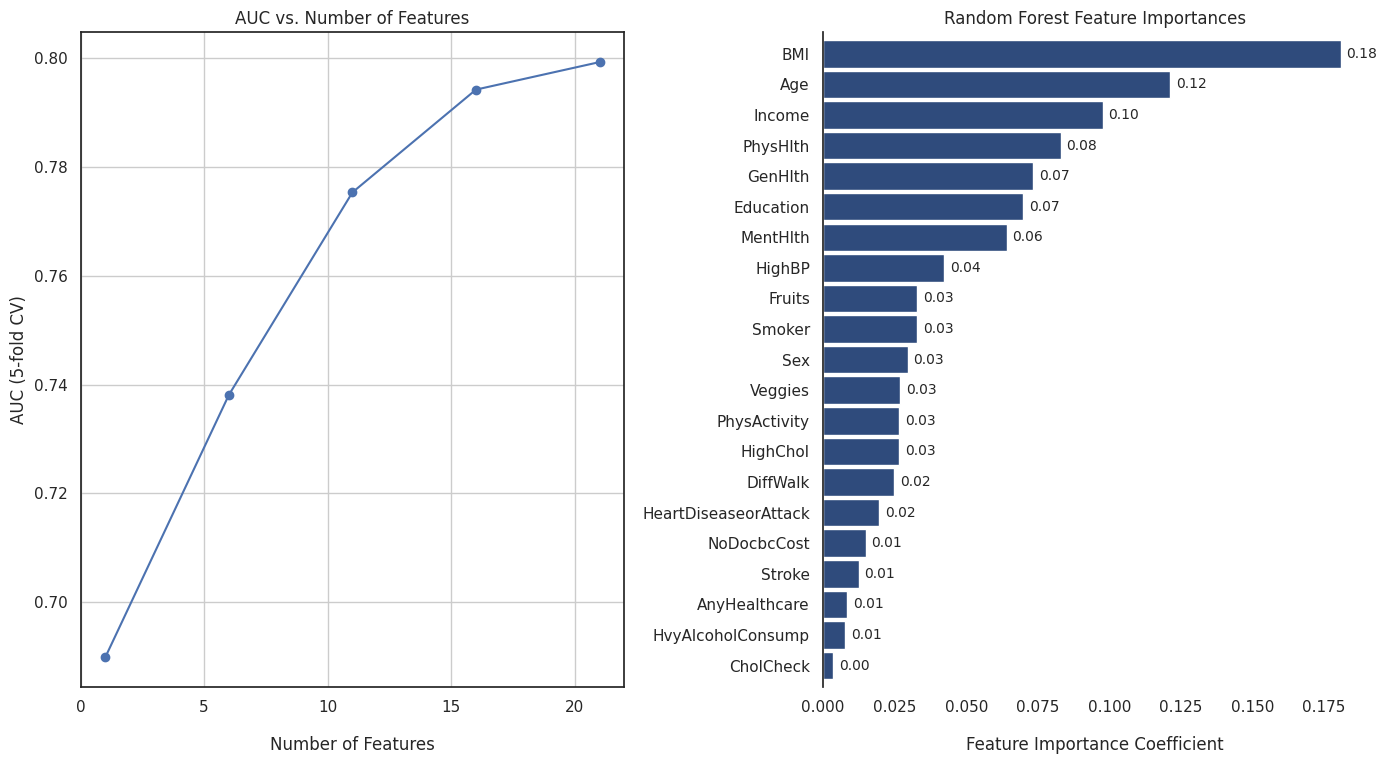

In [20]:
plt.figure(figsize=(14, 7.8))

plt.subplot(1, 2, 1)
plt.plot(num_features_list, auc_scores, marker='o')
plt.xlabel("Number of Features", labelpad=15)
plt.ylabel("AUC (5-fold CV)")
plt.tick_params(axis='both')
plt.title("AUC vs. Number of Features")
plt.xticks([0, 5, 10, 15, 20])
plt.grid(True)
plt.tight_layout()

# subplot 2
plt.subplot(1, 2, 2)
feature_importances_sorted = feature_importances.sort_values()
bars = feature_importances_sorted.plot(kind='barh', width=0.9, color='#2f4b7c')

# Annotate importance scores next to each bar
for index, value in enumerate(feature_importances_sorted):
    plt.text(value + 0.002, index, f"{value:.2f}", va='center', fontsize=10)

plt.xlabel("Feature Importance Coefficient", labelpad=15)
# plt.tick_params(axis='both')
plt.title("Random Forest Feature Importances")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('auc-feature-importance.png')
plt.show()

### **Interpretation:**

After reaching around 14 to 15 features, the AUC score approaches a stable range near 0.80, with only minor increases as more features are added. Therefore the top 15 features will be selected. They are sufficient for achieving a high AUC score, and adding more features yields minimal improvement in AUC.

#### Obtain best predictors for training the models

In [21]:
best_predictors = feature_importances[:15]
print(best_predictors)

BMI             0.180984
Age             0.121404
Income          0.097742
PhysHlth        0.083098
GenHlth         0.073447
Education       0.070024
MentHlth        0.064136
HighBP          0.042377
Fruits          0.032958
Smoker          0.032875
Sex             0.029563
Veggies         0.026841
PhysActivity    0.026585
HighChol        0.026505
DiffWalk        0.024918
dtype: float64


# **Training**

#### Keep best predictors for `X_train_scaled_df`, `X_val_scaled_df`, `X_test_scaled_df`

In [22]:
X_train_scaled_df = X_train_scaled_df.loc[:, best_predictors.index]
X_val_scaled_df = X_val_scaled_df.loc[:, best_predictors.index]
X_test_scaled_df = X_test_scaled_df.loc[:, best_predictors.index]

In [23]:
print(X_train_scaled_df.shape, X_val_scaled_df.shape, X_test_scaled_df.shape)

(152208, 15) (50736, 15) (50736, 15)


### Import algorithms and other tools

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, make_scorer

metric_keys = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']

# summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric + "_mean"] = ht_results.cv_results_["mean_test_" + metric][ht_results.best_index_]
        ht_stats[metric + "_std"] = metric_std = ht_results.cv_results_["std_test_" + metric][ht_results.best_index_]
        if display:
            print("test_" + metric,ht_stats[metric + "_mean"],"("+str(ht_stats[metric + "_std"])+")")
    return ht_stats

# report results
def metric_report(y_test, y_pred, y_pred_proba):
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_proba)

  return {
      "Accuracy": accuracy,
      "F1 score": f1,
      "Precision": precision,
      "Recall": recall,
      "AUC": roc_auc
      }

### Get PCA number of components

In [25]:
pca = PCA()
pca.fit_transform(X_train_scaled_df)

# calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# find the # of components that explain ≥ 99% variance
num_components = np.argmax(explained_variance >= 0.99) + 1 # add 1 because index starts from 0

print(f"Number of components explaining ≥ 99% variance: {num_components}")

pca_correct = PCA(n_components=num_components)

Number of components explaining ≥ 99% variance: 15


#### Resampling and PCA

In [39]:
# define LinearSVC separately for CalibratedClassifierCV to get probabilities
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# resampling the dataset
X_resampled, y_resampled = pipeline.fit_resample(X_train_scaled_df, y_train)

#### View distributions of train, resampled train, validation, test sets

In [40]:
distribution = {
    'Set': ['Train', 'Resampled Train', 'Validation', 'Test'],
    'No Diabetes': [sum(y_train == 0), sum(y_resampled == 0), sum(y_val == 0), sum(y_test == 0)],
    'Diabetes': [sum(y_train == 1), sum(y_resampled == 1), sum(y_val == 1), sum(y_test == 1)]
}

# calculate total counts for each set
total_counts = [len(y_train), len(y_resampled), len(y_val), len(y_test)]

# add percentages
distribution['No Diabetes %'] = [f"{(count / total) * 100:.2f}%" for count, total in zip(distribution['No Diabetes'], total_counts)]
distribution['Diabetes %'] = [f"{(count / total) * 100:.2f}%" for count, total in zip(distribution['Diabetes'], total_counts)]

distribution_df = pd.DataFrame(distribution)
distribution_df

,Set,No Diabetes,Diabetes,No Diabetes %,Diabetes %
0,Train,131000,21208,86.07%,13.93%
1,Resampled Train,78600,39300,66.67%,33.33%
2,Validation,43667,7069,86.07%,13.93%
3,Test,43667,7069,86.07%,13.93%


In [41]:
# apply PCA on resampled training set
X_resampled_pca = pca_correct.fit_transform(X_resampled)

#### LinearSVC

In [42]:
# initalize LinearSVC
svc = LinearSVC()

# wrap with CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc)

# define the parameter grid
param_svc = {
    'estimator__C': [1, 10, 100],
    'estimator__intercept_scaling': [1, 5, 10, 100]
    }

# set up GridSearchCV
grid = GridSearchCV(estimator=calibrated_svc, param_grid=param_svc, refit='f1',
                    cv=kfold, scoring=metric_keys, n_jobs=-1)

# fit gridsearch
grid.fit(X_resampled_pca, y_resampled)

# best perform model + hyperparameter
best_svc = grid.best_estimator_
best_svc_score = grid.best_score_
print(f"Best SVM model: {best_svc}, best refit score: {best_svc_score} \n")

# report mean + std
svc_res = collate_ht_results(grid)
print(f"\nReport the mean and standard deviation: {svc_res}")

Best SVM model: CalibratedClassifierCV(estimator=LinearSVC(C=1)), best refit score: 0.5979913282893153 

test_roc_auc 0.8214607424484921 (0.0032252994763093995)
test_accuracy 0.7553011026293468 (0.003740448398742121)
test_f1 0.5979913282893153 (0.004412565754547944)
test_precision 0.660929094897606 (0.004363842439374371)
test_recall 0.5460068325756285 (0.004875579179399592)

Report the mean and standard deviation: {'roc_auc_mean': 0.8214607424484921, 'roc_auc_std': 0.0032252994763093995, 'accuracy_mean': 0.7553011026293468, 'accuracy_std': 0.003740448398742121, 'f1_mean': 0.5979913282893153, 'f1_std': 0.004412565754547944, 'precision_mean': 0.660929094897606, 'precision_std': 0.004363842439374371, 'recall_mean': 0.5460068325756285, 'recall_std': 0.004875579179399592}


#### Logistic Regression

In [43]:
lr = LogisticRegression()

# set param for LR model
param_lr = {
    'C': np.logspace(-4, 4, 20),
    }

grid.set_params(estimator=lr, param_grid=param_lr)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             refit='f1',
             scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'])

In [44]:
# fitting
grid.fit(X_resampled_pca, y_resampled)

# best perform model + hyperparameter
best_lr = grid.best_estimator_
print(f"Best LR model: {best_lr} \n")

# report mean + std
lr_res = collate_ht_results(grid)
print(f"\nReport the mean and standard deviation: {lr_res}")

Best LR model: LogisticRegression(C=1.623776739188721) 

test_roc_auc 0.8215042951533725 (0.0032697117275332977)
test_accuracy 0.7551823579304495 (0.003492427565867724)
test_f1 0.5990942925148028 (0.0047351904421167315)
test_precision 0.6595559852473541 (0.00517970346214363)
test_recall 0.5487968656904199 (0.0049576118253360285)

Report the mean and standard deviation: {'roc_auc_mean': 0.8215042951533725, 'roc_auc_std': 0.0032697117275332977, 'accuracy_mean': 0.7551823579304495, 'accuracy_std': 0.003492427565867724, 'f1_mean': 0.5990942925148028, 'f1_std': 0.0047351904421167315, 'precision_mean': 0.6595559852473541, 'precision_std': 0.00517970346214363, 'recall_mean': 0.5487968656904199, 'recall_std': 0.0049576118253360285}


#### Random Forest

In [45]:
# set param for RF model
rf_new = RandomForestClassifier(n_jobs=-1)

param_rf = {'max_depth' : [4, 6, 8],
            'n_estimators': [100, 200, 300]
            }

grid.set_params(estimator=rf_new, param_grid=param_rf)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             refit='f1',
             scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'])

In [46]:
# time cross-validation performance
grid.fit(X_resampled_pca, y_resampled)

# best perform model + hyperparameter
best_rf = grid.best_estimator_
print(f"Best RF model: {best_rf} \n")

# report mean + std
rf_res = collate_ht_results(grid)
print(f"\nReport the mean and standard deviation: {rf_res}")

Best RF model: RandomForestClassifier(max_depth=8, n_jobs=-1) 

test_roc_auc 0.8233326991058669 (0.003266734629537248)
test_accuracy 0.761119592875318 (0.0046230983806306416)
test_f1 0.6074499070104331 (0.004546670891517423)
test_precision 0.6716477371059933 (0.004790082363804021)
test_recall 0.5544661737244508 (0.005032085352951835)

Report the mean and standard deviation: {'roc_auc_mean': 0.8233326991058669, 'roc_auc_std': 0.003266734629537248, 'accuracy_mean': 0.761119592875318, 'accuracy_std': 0.0046230983806306416, 'f1_mean': 0.6074499070104331, 'f1_std': 0.004546670891517423, 'precision_mean': 0.6716477371059933, 'precision_std': 0.004790082363804021, 'recall_mean': 0.5544661737244508, 'recall_std': 0.005032085352951835}


#### Gradient Boosting

In [47]:
from xgboost import cv
import xgboost as xgb

xgb_cl = XGBClassifier(n_estimators=1000, n_jobs=-1)

param_xgb = {'max_depth': [4, 6, 8],
             'learning_rate': [0.001, 0.002, 0.01]
             }

grid.set_params(estimator=xgb_cl, param_grid=param_xgb)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     int...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.002, 0.01],
                         'max_depth': [4, 6, 8]},
             refit='f1',
             scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'])

In [48]:
# time cross-validation performance
grid.fit(X_resampled_pca, y_resampled)

# best perform model + hyperparameter
best_xgb = grid.best_estimator_
print(f"Best XGB model: {best_xgb} \n")

# report mean + std
xgb_res = collate_ht_results(grid)
print(f"\nReport the mean and standard deviation: {xgb_res}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...) 

test_roc_auc 0.8479364764635541 (0.0029959353832904783)
test_accuracy 0.7763952502120441 (0.0026425289961397444)
test_f1 0.651244042830185 (0.003781696121711929)
test_precision 0.6782122211275864 (0.005105470740775181)
test_recal

#### Multilayer Perceptron

In [49]:
mlp = MLPClassifier(max_iter=100)

param_mlp = {'hidden_layer_sizes':
             [(10,), (20,), (50,),
              (10, 10), (20, 20), (50, 50),
              (10, 10, 10), (20, 20, 20), (50, 50, 50)],
             'learning_rate_init': [1e-5, 0.01, 0.1, 1, 10, 50],
             }

grid.set_params(estimator=mlp, param_grid=param_mlp)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(10,), (20,), (50,), (10, 10),
                                                (20, 20), (50, 50),
                                                (10, 10, 10), (20, 20, 20),
                                                (50, 50, 50)],
                         'learning_rate_init': [1e-05, 0.01, 0.1, 1, 10, 50]},
             refit='f1',
             scoring=['roc_auc', 'accuracy', 'f1', 'precision', 'recall'])

In [50]:
# time cross-validation performance
grid.fit(X_resampled_pca, y_resampled)

# best perform model + hyperparameter
best_mlp = grid.best_estimator_
print(f"Best MLP model: {best_mlp} \n")

# report mean + std
mlp_res = collate_ht_results(grid)
print(f"\nReport the mean and standard deviation: {mlp_res}")

Best MLP model: MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=100) 

test_roc_auc 0.8310801174774671 (0.0033379413936107127)
test_accuracy 0.7646395250212044 (0.002906833126002125)
test_f1 0.6429289513262226 (0.008553239489349971)
test_precision 0.6504396892823295 (0.008201171656062985)
test_recall 0.6361260907818892 (0.020191917552560598)

Report the mean and standard deviation: {'roc_auc_mean': 0.8310801174774671, 'roc_auc_std': 0.0033379413936107127, 'accuracy_mean': 0.7646395250212044, 'accuracy_std': 0.002906833126002125, 'f1_mean': 0.6429289513262226, 'f1_std': 0.008553239489349971, 'precision_mean': 0.6504396892823295, 'precision_std': 0.008201171656062985, 'recall_mean': 0.6361260907818892, 'recall_std': 0.020191917552560598}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### **Report mean and STD**

In [51]:
def mean_std(model_grid):

   # initialize a list to collect data
    mean_std_data = []

    # loop through the dictionary
    for classifier_name, metrics in model_grid.items():
        mean_std_data.append({
            'Classifier': classifier_name,
            'Mean Test ROC AUC': metrics['roc_auc_mean'],
            'STD Test ROC AUC': metrics['roc_auc_std'],
            'Mean Test Accuracy': metrics['accuracy_mean'],
            'STD Test Accuracy': metrics['accuracy_std'],
            'Mean Test F1': metrics['f1_mean'],
            'STD Test F1': metrics['f1_std'],
            'Mean Test Precision': metrics['precision_mean'],
            'STD Test Precision': metrics['precision_std'],
            'Mean Test Recall': metrics['recall_mean'],
            'STD Test Recall': metrics['recall_std'],
        })

    # convert the list of dictionaries into a DataFrame
    mean_std_df = pd.DataFrame(mean_std_data)

    return mean_std_df

In [52]:
models_grid = {'LR': lr_res, 'SVM': svc_res, 'RF': rf_res,
               'XGB': xgb_res, 'MLP': mlp_res}

mean_std_df = mean_std(models_grid)

In [53]:
mean_std_df_transpose = mean_std_df.T
mean_std_df_transpose.rename_axis('Classifier', axis=0, inplace=True)
mean_std_df_transpose

,0,1,2,3,4
Classifier,,,,,
Classifier,LR,SVM,RF,XGB,MLP
Mean Test ROC AUC,0.821504,0.821461,0.823333,0.847936,0.83108
STD Test ROC AUC,0.00327,0.003225,0.003267,0.002996,0.003338
Mean Test Accuracy,0.755182,0.755301,0.76112,0.776395,0.76464
STD Test Accuracy,0.003492,0.00374,0.004623,0.002643,0.002907
Mean Test F1,0.599094,0.597991,0.60745,0.651244,0.642929
STD Test F1,0.004735,0.004413,0.004547,0.003782,0.008553
Mean Test Precision,0.659556,0.660929,0.671648,0.678212,0.65044
STD Test Precision,0.00518,0.004364,0.00479,0.005105,0.008201


### **Combine training and validation set**

In [54]:
# combine train and validation sets
X_train_val = pd.concat([X_train_scaled_df, X_val_scaled_df], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [55]:
print(X_train_val.shape, y_train_val.shape, type(y_train_val))

(202944, 15) (202944,) <class 'pandas.core.series.Series'>


In [56]:
X_train_val.head()

,BMI,Age,Income,PhysHlth,GenHlth,Education,MentHlth,HighBP,Fruits,Smoker,Sex,Veggies,PhysActivity,HighChol,DiffWalk
0,0.698410,-0.666938,-0.026044,-0.486611,-1.414129,0.963110,-0.429925,-0.867897,0.758449,-0.892014,-0.889369,0.481285,0.56687,-0.858440,-0.449127
1,0.396180,1.300902,0.456208,0.660244,2.329597,0.963110,-0.429925,-0.867897,0.758449,-0.892014,1.124393,0.481285,0.56687,1.164904,2.226543
2,-0.812739,1.300902,0.456208,-0.486611,-1.414129,0.963110,-0.429925,1.152210,0.758449,-0.892014,-0.889369,0.481285,0.56687,1.164904,-0.449127
3,-0.661624,0.644955,0.456208,-0.486611,0.457734,-0.051768,-0.429925,1.152210,-1.318481,1.121059,1.124393,-2.077769,0.56687,1.164904,-0.449127
4,1.453985,0.316982,-0.508297,-0.486611,0.457734,-1.066646,-0.429925,-0.867897,0.758449,-0.892014,-0.889369,-2.077769,0.56687,1.164904,-0.449127


### **Threshold tuning**

#### Apply PCA on test set

In [57]:
X_test_pca = pca_correct.transform(X_test_scaled_df)

#### Tuning

In [59]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_lr = TunedThresholdClassifierCV(
    best_lr,
    scoring="f1",
    store_cv_results=True,
  )

tuned_lr.fit(X_resampled_pca, y_resampled)

print(f"Average F1 on the training set: {tuned_lr.best_score_:.3f}" )
print(f'Threshold: {tuned_lr.best_threshold_: .3f}')

Average F1 on the training set: 0.663
Threshold:  0.307


In [60]:
tuned_svc = TunedThresholdClassifierCV(
    best_svc,
    scoring="f1",
    store_cv_results=True,
  )

tuned_svc.fit(X_resampled_pca, y_resampled)

print(f"Average F1 on the training set: {tuned_svc.best_score_:.3f}" )
print(f'Threshold: {tuned_svc.best_threshold_: .3f}')

Average F1 on the training set: 0.663
Threshold:  0.317


In [61]:
tuned_rf = TunedThresholdClassifierCV(
    best_rf,
    scoring="f1",
    store_cv_results=True,
  )

tuned_rf.fit(X_resampled_pca, y_resampled)

print(f"Average F1 on the training set: {tuned_rf.best_score_:.3f}" )
print(f'Threshold: {tuned_rf.best_threshold_: .3f}')

Average F1 on the training set: 0.661
Threshold:  0.368


In [62]:
tuned_xgb = TunedThresholdClassifierCV(
    best_xgb,
    scoring="f1",
    store_cv_results=True,
  )

tuned_xgb.fit(X_resampled_pca, y_resampled)

print(f"Average F1 on the training set: {tuned_xgb.best_score_:.3f}" )
print(f'Threshold: {tuned_xgb.best_threshold_: .3f}')

Average F1 on the training set: 0.689
Threshold:  0.336


In [63]:
tuned_mlp = TunedThresholdClassifierCV(
    best_mlp,
    scoring="f1",
    store_cv_results=True,
  )

tuned_mlp.fit(X_resampled_pca, y_resampled)

print(f"Average F1 on the training set: {tuned_mlp.best_score_:.3f}" )
print(f'Threshold: {tuned_mlp.best_threshold_: .3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Average F1 on the training set: 0.673
Threshold:  0.333


In [65]:
# get the best threshold
from sklearn.model_selection import FixedThresholdClassifier

# lr
tuned_best_lr = FixedThresholdClassifier(best_lr, threshold=tuned_lr.best_threshold_)

# rf
tuned_best_rf = FixedThresholdClassifier(best_rf, threshold=tuned_rf.best_threshold_)

# svc
tuned_best_svc = FixedThresholdClassifier(best_svc, threshold=tuned_svc.best_threshold_)

# xgb
tuned_best_xgb = FixedThresholdClassifier(best_xgb, threshold=tuned_xgb.best_threshold_)

# mlp
tuned_best_mlp = FixedThresholdClassifier(best_mlp, threshold=tuned_mlp.best_threshold_)

print(tuned_best_lr, '\n', tuned_best_rf, '\n', tuned_best_svc, '\n', tuned_best_xgb, '\n', tuned_best_mlp)

FixedThresholdClassifier(estimator=LogisticRegression(C=1.623776739188721),
                         threshold=0.30664019660139097) 
 FixedThresholdClassifier(estimator=RandomForestClassifier(max_depth=8,
                                                          n_jobs=-1),
                         threshold=0.3681843130463325) 
 FixedThresholdClassifier(estimator=CalibratedClassifierCV(estimator=LinearSVC(C=1)),
                         threshold=0.3170725054901468) 
 FixedThresholdClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                         

### **Helper functions to assess the prediction performance and execution times**


In [85]:
def fit_model_and_get_predictions(pipeline, classifier, X_train_val, y_train_val, X_test, y_test, pca):
  if pipeline == 'none':
      # skip resampling, directly use original training data
      X_train_val_resampled, y_train_val_resampled = X_train_val, y_train_val
  else:
      # apply resampling pipeline
      X_train_val_resampled, y_train_val_resampled = pipeline.fit_resample(X_train_val, y_train_val)

  # apply PCA
  X_resampled_pca = pca_correct.fit_transform(X_train_val_resampled)

  # get train + val execution time
  start_time = time()
  classifier.fit(X_resampled_pca, y_train_val_resampled)
  train_val_ex_time = time() - start_time

  # get test execution time
  start_time = time()
  y_pred = classifier.predict(X_test)
  y_pred_proba = classifier.predict_proba(X_test)[:, 1]
  test_pred_ex_time = time() - start_time

  # get performance for test set
  test_report = metric_report(y_test, y_pred, y_pred_proba)

  model_and_predictions_dict = {'pipeline': pipeline,
                                'classifier': classifier,
                                'training_execution_time': train_val_ex_time,
                                'prediction_execution_time': test_pred_ex_time,
                                'total_execution_time': train_val_ex_time + test_pred_ex_time,
                                'test_report': test_report
                                }

  return model_and_predictions_dict

In [67]:
def execution_times_model_collection(fitted_models_and_predictions_dict):

   # initialize a list to collect data
    execution_times_data = []

    # loop through the dictionary
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dict.items():
        execution_times_data.append({
            'Classifier': classifier_name,
            'Total execution time (s)': model_and_predictions['total_execution_time']
        })

    # convert the list of dictionaries into a DataFrame
    execution_times = pd.DataFrame(execution_times_data)

    return execution_times

### **Create pipelines to test different method on combined set**

In [68]:
# SMOTE
step_smote_pca = [('o', SMOTE())]
pipeline_1 = Pipeline(steps=step_smote_pca)

# Under
step_under_pca = [('u', RandomUnderSampler())]
pipeline_2 = Pipeline(steps=step_under_pca)

# SMOTE
step_both_pca = [('o', over), ('u', under)]
pipeline_3 = Pipeline(steps=step_both_pca)

### **Train on train + validation set and assess on test set**

In [88]:
models_dict = {'LR': tuned_best_lr, 'SVC': tuned_best_svc, 'RF': tuned_best_rf,
               'GBT': tuned_best_xgb, 'MLP': tuned_best_mlp
               }

pipelines = ['none', pipeline_1, pipeline_2, pipeline_3]

fitted_models_and_pred_dict = {}

for model_name, model in models_dict.items():
    for i, pipeline in enumerate(pipelines):
        # create a unique key for each model-pipeline combination
        key = f"{model_name}_Pipeline_{i+1}"
        fitted_models_and_pred_dict[key] = fit_model_and_get_predictions(
            pipeline=pipeline,
            classifier=model,
            X_train_val=X_train_val,
            y_train_val=y_train_val,
            X_test=X_test_pca,
            y_test=y_test,
            pca=pca_correct
        )

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [89]:
fitted_models_and_pred_dict

{'LR_Pipeline_1': {'pipeline': 'none',
  'classifier': FixedThresholdClassifier(estimator=LogisticRegression(C=1.623776739188721),
                           threshold=0.30664019660139097),
  'training_execution_time': 0.25003933906555176,
  'prediction_execution_time': 0.007314920425415039,
  'total_execution_time': 0.2573542594909668,
  'test_report': {'Accuracy': 0.8521168401135288,
   'F1 score': 0.3606305922454197,
   'Precision': 0.453493356193742,
   'Recall': 0.2993351251945112,
   'AUC': 0.8124948322630372}},
 'LR_Pipeline_2': {'pipeline': Pipeline(steps=[('o', SMOTE())]),
  'classifier': FixedThresholdClassifier(estimator=LogisticRegression(C=1.623776739188721),
                           threshold=0.30664019660139097),
  'training_execution_time': 0.5954103469848633,
  'prediction_execution_time': 0.007231950759887695,
  'total_execution_time': 0.602642297744751,
  'test_report': {'Accuracy': 0.46556685588142543,
   'F1 score': 0.2907217034188705,
   'Precision': 0.178337612

In [91]:
# get execution time
execution_time_df = execution_times_model_collection(fitted_models_and_pred_dict)
execution_time_df

,Classifier,Total execution time (s)
0,LR_Pipeline_1,0.257354
1,LR_Pipeline_2,0.602642
2,LR_Pipeline_3,0.088735
3,LR_Pipeline_4,0.273410
4,SVC_Pipeline_1,3.003733
5,SVC_Pipeline_2,3.817049
6,SVC_Pipeline_3,0.547689
7,SVC_Pipeline_4,1.860491
8,RF_Pipeline_1,65.778563
9,RF_Pipeline_2,118.375367


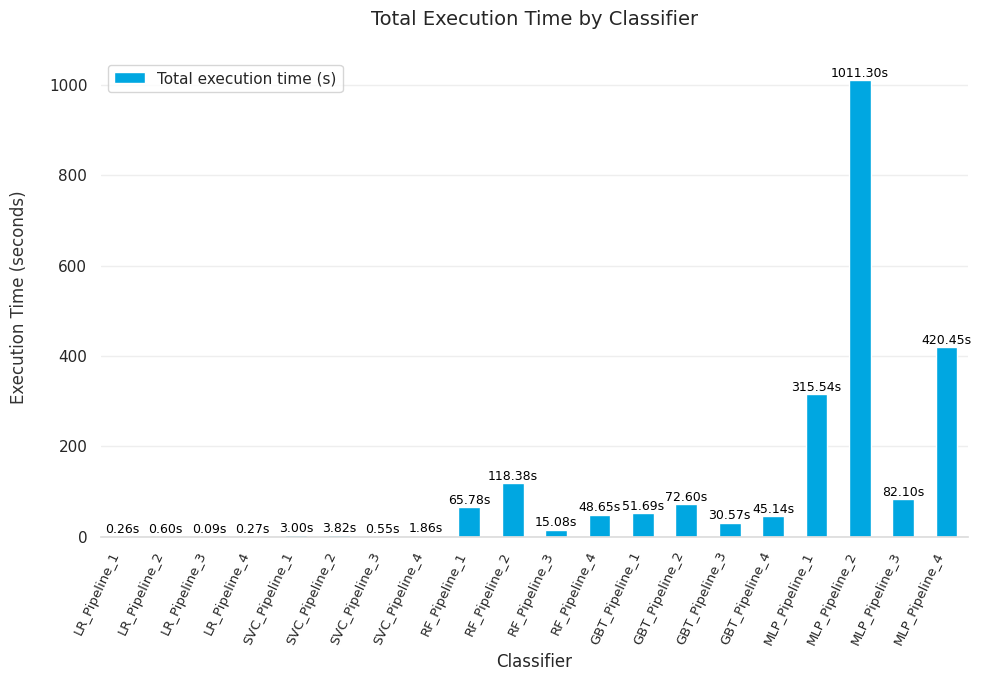

In [104]:
fig, ax = plt.subplots(figsize=(10, 7))

execution_time_df.plot(
    x="Classifier",
    kind="bar",
    stacked=True,
    color=['#00a7e1', '#ff5348'],
    ax=ax
)

plt.xticks(rotation=65, ha="right", fontsize=9.5)

ax.set_ylabel('Execution Time (seconds)', labelpad=15, color='#333333')
ax.set_title('Total Execution Time by Classifier', y=1.05, fontsize=14)

# add proper annotations for stacked bars
for i, classifier in enumerate(execution_time_df["Classifier"]):
    total_time = execution_time_df.loc[i, "Total execution time (s)"]

    ax.text(
          i, total_time + 15,  # Halfway up the prediction bar
          f"{total_time:.2f}s", ha="center", va="center", color="black", fontsize=9
      )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

plt.tight_layout()
plt.savefig('execution.png')
plt.show()

#### **Plot performance metric**

In [129]:
results = {}

pipelines = ['Pipeline_1', 'Pipeline_2', 'Pipeline_3', 'Pipeline_4']
classifiers = ['LR', 'SVC', 'RF', 'GBT', 'MLP']

for pipeline in pipelines:
    results[pipeline] = {}
    for classifier in classifiers:
        metrics = {
            "Accuracy": fitted_models_and_pred_dict[classifier + '_' + pipeline]['test_report']['Accuracy'],
            "F1 score": fitted_models_and_pred_dict[classifier + '_' + pipeline]['test_report']['F1 score'],
            "Precision": fitted_models_and_pred_dict[classifier + '_' + pipeline]['test_report']['Precision'],
            "Recall": fitted_models_and_pred_dict[classifier + '_' + pipeline]['test_report']['Recall'],
            "AUC": fitted_models_and_pred_dict[classifier + '_' + pipeline]['test_report']['AUC'],
        }
        results[pipeline][classifier] = metrics

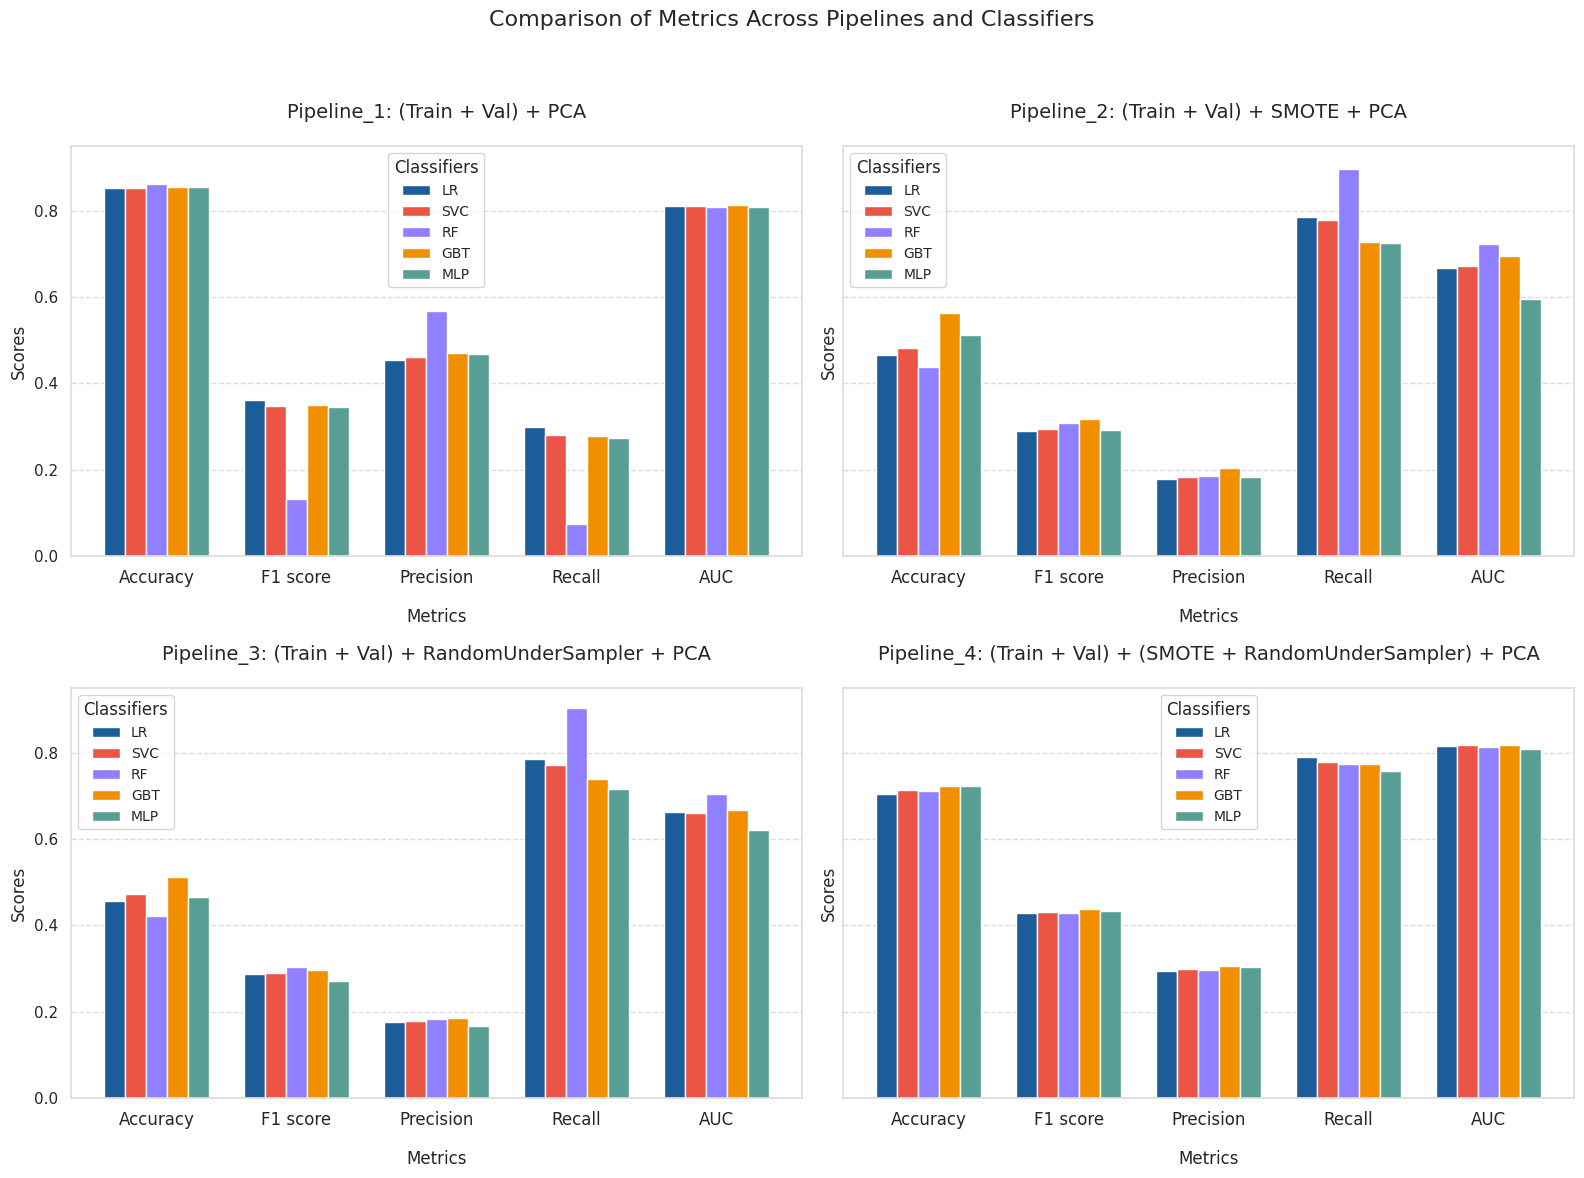

In [143]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'F1 score', 'Precision', 'Recall', 'AUC']

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes = axes.flatten()

colors = ['#1C5D99', "#ea5545", '#9080ff', '#F18F01', '#599e94']

pipeline_details = ['(Train + Val) + PCA', '(Train + Val) + SMOTE + PCA',
                    '(Train + Val) + RandomUnderSampler + PCA',
                    '(Train + Val) + (SMOTE + RandomUnderSampler) + PCA']

bar_width = 0.15

for idx, (pipeline, pipeline_results) in enumerate(results.items()):
    classifiers = list(pipeline_results.keys())

    # extract scores for each metric and classifier
    scores = {metric: [pipeline_results[classifier][metric] for classifier in classifiers] for metric in metrics}

    x = np.arange(len(metrics))

    # current subplot
    ax = axes[idx]

    # plot each classifier's bars
    for i, classifier in enumerate(classifiers):
        ax.bar(x + i * bar_width, [scores[metric][i] for metric in metrics], bar_width, label=classifier, color=colors[i])

    # customize the subplot
    ax.set_title(f'{pipeline}: {pipeline_details[idx]}', fontsize=14, y=1.05)
    ax.set_xticks(x + bar_width * (len(classifiers) - 1) / 2)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_xlabel('Metrics', fontsize=12, labelpad=15)
    ax.set_ylabel('Scores', fontsize=12)
    ax.legend(title='Classifiers', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # adjust spines' colors
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['top'].set_color('#DDDDDD')
    ax.spines['right'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')

# set overall figure title and layout
fig.suptitle('Comparison of Metrics Across Pipelines and Classifiers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('results_compare.png')
plt.show()

## **Obtain SHAP value**

In [ ]:
from sklearn.cluster import KMeans

background_kmeans = shap.kmeans(X_train_val, 50)

X_shap = X_test_scaled_df.sample(frac=0.02)

#### **Support Vector Machine**

In [ ]:
# create SHAP explainer for SVM (uses KernelExplainer)
svm_explainer = shap.KernelExplainer(best_svc.predict, background_kmeans)

# compute SHAP values
svm_shap = svm_explainer.shap_values(X_shap)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


  0%|          | 0/1015 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have

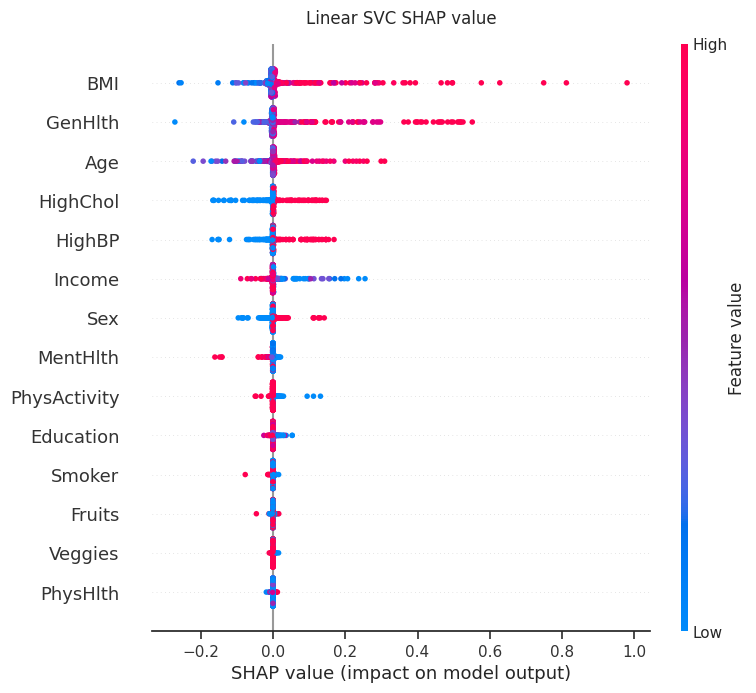

In [ ]:
# Visualize SHAP summary plot
shap.summary_plot(svm_shap, X_shap, show=False)
plt.title("Linear SVC SHAP value", y=1.02)
plt.tight_layout()
plt.savefig('svm_shap.png')

#### **Logistic Regression**

In [ ]:
# create SHAP explainer for LR
lr_explainer = shap.KernelExplainer(best_lr.predict, background_kmeans)

# compute SHAP values
lr_shap = lr_explainer.shap_values(X_shap)

  0%|          | 0/1015 [00:00<?, ?it/s]

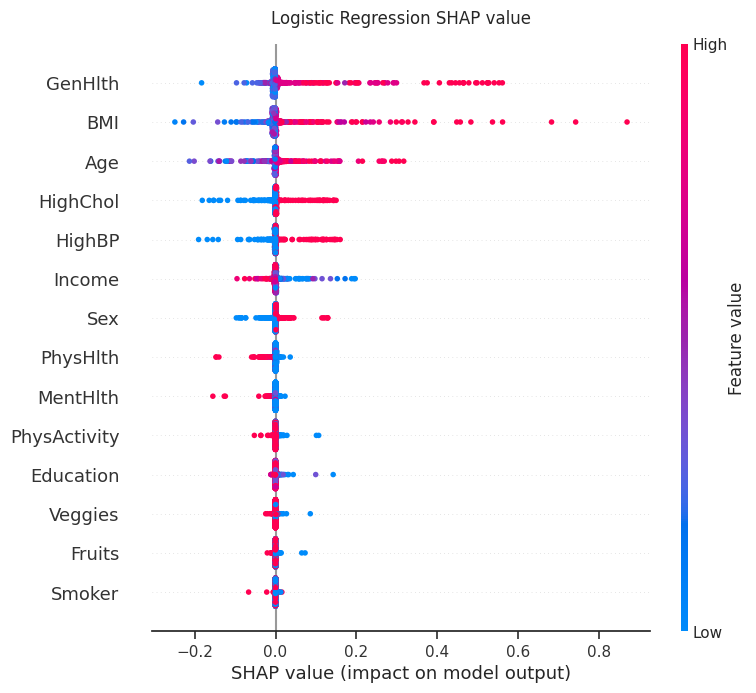

In [ ]:
# visualize SHAP summary plot
shap.summary_plot(lr_shap, X_shap, show=False)
plt.title("Logistic Regression SHAP value", y=1.02)
plt.tight_layout()
plt.savefig('lr_shap.png')

#### **Random Forest**

In [ ]:
# create SHAP explainer for RF
rf_explainer = shap.KernelExplainer(best_rf.predict, background_kmeans)

# compute SHAP values
rf_shap = rf_explainer.shap_values(X_shap)

  0%|          | 0/1015 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_

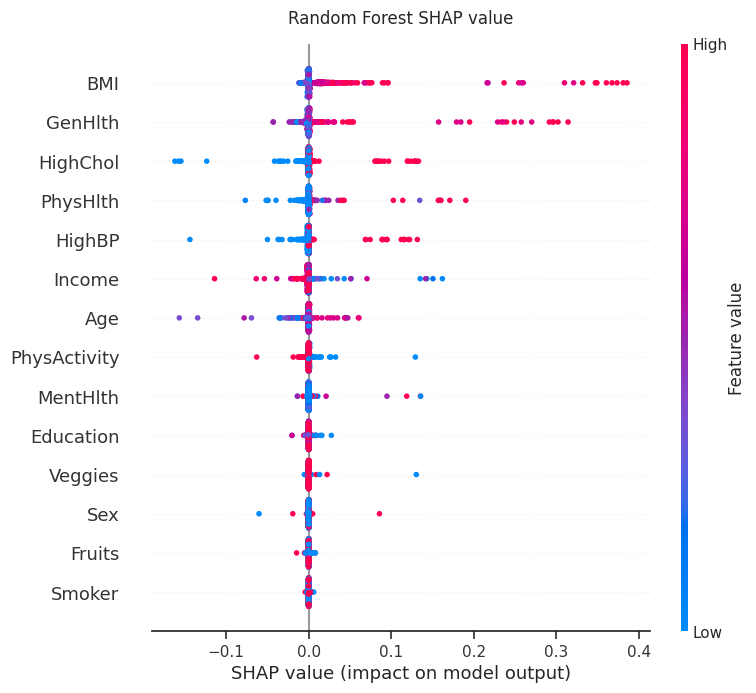

In [ ]:
# visualize SHAP summary plot
shap.summary_plot(rf_shap, X_shap, show=False)
plt.title("Random Forest SHAP value", y=1.02)
plt.tight_layout()
plt.savefig('rf_shap.png')

#### **Gradient Boosting**

In [ ]:
# create SHAP explainer for RF
xgb_explainer = shap.TreeExplainer(best_xgb)

# compute SHAP values
xgb_shap = xgb_explainer.shap_values(X_shap)

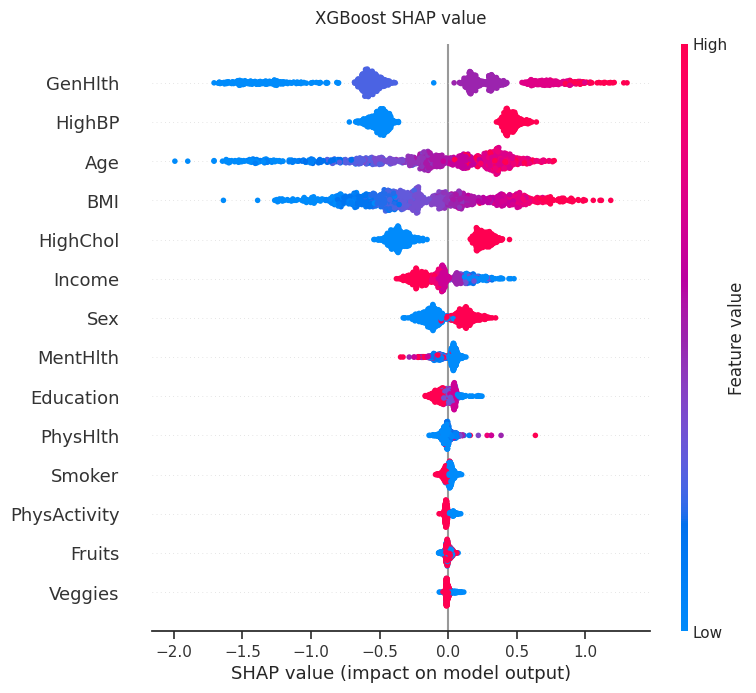

In [ ]:
# visualize SHAP summary plot
shap.summary_plot(xgb_shap, X_shap, show=False)
plt.title("XGBoost SHAP value", y=1.02)
plt.tight_layout()
plt.savefig('xgb_shap.png')

#### **Multilayer Perceptron**

In [ ]:
# create SHAP explainer for RF
mlp_explainer = shap.KernelExplainer(best_mlp.predict, background_kmeans)

# compute SHAP values
mlp_shap = mlp_explainer.shap_values(X_shap)

  0%|          | 0/1015 [00:00<?, ?it/s]

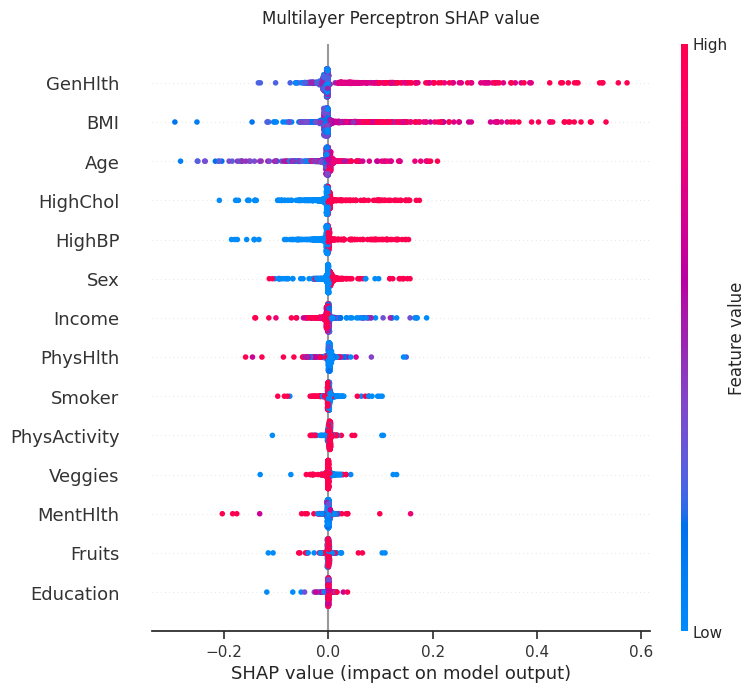

In [ ]:
# visualize SHAP summary plot
shap.summary_plot(mlp_shap, X_shap, show=False)
plt.title("Multilayer Perceptron SHAP value", y=1.02)
plt.tight_layout()
plt.savefig('mlp_shap.png')